In [1]:
import pandas as pd
import matplotlib.pyplot as plt
import dateutil.parser
import numpy as np
import scipy.stats as st
import seaborn as sns

from matplotlib.lines import Line2D
from tqdm import tqdm
from datetime import timedelta, datetime
from sklearn.decomposition import NMF
from pandas.plotting import table

In [2]:
tqdm.pandas()

In [3]:
billboard_hot_100 = pd.read_csv("billboard_hot_100.csv")
billboard_hot_100["first_day_of_the_week"] = pd.to_datetime(billboard_hot_100["first_day_of_the_week"],
                                                            infer_datetime_format=True)
billboard_hot_100["year"] = billboard_hot_100["first_day_of_the_week"].dt.year
billboard_hot_100.head()

,Unnamed: 0,first_day_of_the_week,artist,song_name,position,last_week_position,peak_position,weeks_on_chart,songwriters,producers,promotion_label,year
1611,1611,1959-01-12,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,7,Not Listed,Not Listed,Liberty,1959
1615,1615,1959-01-05,The Chipmunks With David Seville,The Chipmunk Song,1,1.0,1,6,Not Listed,Not Listed,Liberty,1959
1628,1628,1959-01-12,The Platters,Smoke Gets In Your Eyes,2,2.0,2,9,"O.Harbach, J.Kern",Not Listed,Mercury,1959
1629,1629,1959-01-12,Connie Francis,My Happiness,3,6.0,3,6,"B.Bergantine, B.Peterson",Not Listed,MGM,1959
1630,1630,1959-01-12,Billy Grammer,Gotta Travel On,4,9.0,4,8,"P.Clayton, L.Ehrlich, R.Gilbert, L.Hays, F.Hel...",Not Listed,Monument,1959


In [4]:
plt.rcParams.update({'font.size': 15})

In [5]:
billboard_hot_100["artist_song"] = billboard_hot_100["artist"] + " - " +\
    billboard_hot_100["song_name"]
billboard_hot_100["top_position"] = billboard_hot_100.groupby("artist_song")["position"].transform("min")

In [6]:
# https://stackoverflow.com/questions/13728392/moving-average-or-running-mean
def moving_average(x, w):
    return np.convolve(x, np.ones(w) / w, 'valid')

In [7]:
number_of_songs = billboard_hot_100[["artist", "song_name"]].drop_duplicates().groupby("artist")["song_name"].count().reset_index(name="song_count")
billboard_hot_100["number_of_songs"] = billboard_hot_100["artist"].progress_map(lambda artist: number_of_songs[number_of_songs["artist"] == artist]["song_count"].iloc[0])

100%|██████████| 333887/333887 [03:47<00:00, 1466.50it/s]


In [8]:
numbers_of_songs = billboard_hot_100[["artist", "number_of_songs"]].drop_duplicates()
count_numbers_of_songs = numbers_of_songs["number_of_songs"].value_counts().sort_index()

In [9]:
billboard_hot_100["top_10"] = billboard_hot_100["top_position"] <= 10
number_of_songs_10 = billboard_hot_100[["artist", "song_name", "top_10"]].drop_duplicates().groupby("artist")["top_10"].sum().reset_index(name="top_10_count")

In [10]:
artist_song = billboard_hot_100.sort_values(
        "first_day_of_the_week")[["artist", "song_name"]].drop_duplicates()

for i in range(0, 51):
    artist_song[f"{i + 1}th_song"] = artist_song.groupby("artist")["song_name"].transform("nth", i)

In [11]:
billboard_hot_100 = pd.merge(billboard_hot_100, artist_song, on=["artist", "song_name"], how="left")

In [12]:
def get_past_weeks(row):
    top_position = row["top_position"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    past_weeks = row[
        (row["first_day_of_the_week"] <= top_position_time)]["weeks_on_chart"].max()
    return past_weeks

def get_future_weeks(row):
    top_position = row["top_position"].iloc[0]
    past_weeks = row["past_weeks"].iloc[0]
    # take first day of the week when the song was in top position
    top_position_time = row[
        (row["position"] == top_position)]["first_day_of_the_week"].values[0]
    max_weeks = row[
        (row["first_day_of_the_week"] > top_position_time)]["weeks_on_chart"].max()
    if max_weeks is np.nan or max_weeks == 0:
        return 0
    future_weeks = max_weeks - past_weeks
    if future_weeks is np.nan or future_weeks < 0:
        return 0
    return future_weeks

df_past_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_past_weeks(row)).rename("past_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_past_weeks[["artist", "song_name", "past_weeks"]], on=["artist", "song_name"], how="left")

df_future_weeks = billboard_hot_100.groupby(["artist", "song_name"]).progress_apply(
    lambda row: get_future_weeks(row)).rename("future_weeks").reset_index()

billboard_hot_100 = billboard_hot_100.merge(df_future_weeks[["artist", "song_name", "future_weeks"]], on=["artist", "song_name"], how="left")

100%|██████████| 30147/30147 [00:24<00:00, 1221.70it/s]


In [13]:
billboard_hot_100["max_weeks_on_chart"] = billboard_hot_100.groupby(["artist", "song_name"])["weeks_on_chart"].transform("max")

billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("first")["position"]
billboard_hot_100["last_position"] = billboard_hot_100.sort_values(
    by="first_day_of_the_week").groupby(["artist", "song_name"])["position", "first_day_of_the_week"].transform("last")["position"]

C:\Users\Giercowanie\AppData\Local\Temp\ipykernel_16124\3272273204.py:3: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["first_position"] = billboard_hot_100.sort_values(
C:\Users\Giercowanie\AppData\Local\Temp\ipykernel_16124\3272273204.py:5: FutureWarning: Indexing with multiple keys (implicitly converted to a tuple of keys) will be deprecated, use a list instead.
  billboard_hot_100["last_position"] = billboard_hot_100.sort_values(


In [14]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

## Statistics for hitmakers vs not-hitmakers

In [15]:
hitmakers = billboard_hot_100[billboard_hot_100["number_of_songs"] > 10]
not_hitmakers = billboard_hot_100[billboard_hot_100["number_of_songs"] <= 10]

Hitmakers


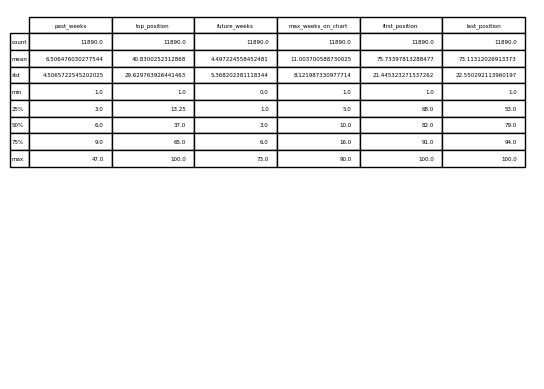

Not-hitmakers


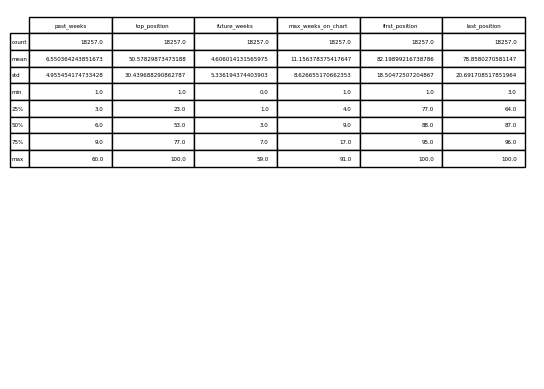

In [16]:
print("Hitmakers")
hitmakers_subdf = hitmakers[["artist", "song_name"] + features].drop_duplicates()
hitmakers_describe = hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/hitmakers_statistics.pdf', format="pdf")
plt.show()

print("Not-hitmakers")
not_hitmakers_subdf = not_hitmakers[["artist", "song_name"] + features].drop_duplicates()
not_hitmakers_describe = not_hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, not_hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/not_hitmakers_statistics.pdf', format="pdf")
plt.show()

### 1st song

Hitmakers


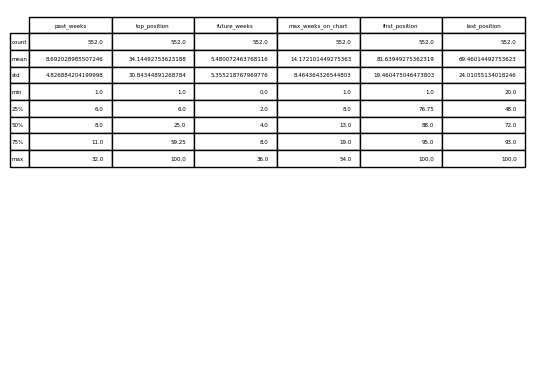

Not-hitmakers


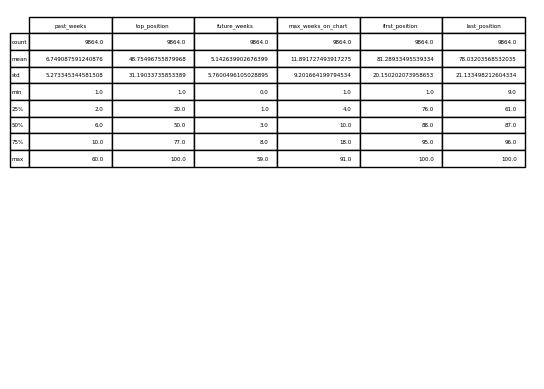

In [17]:
print("Hitmakers")
hitmakers_subdf_1st = hitmakers[hitmakers["song_name"] == hitmakers["1th_song"]]
hitmakers_subdf = hitmakers_subdf_1st[["artist", "song_name"] + features].drop_duplicates()
hitmakers_describe = hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/hitmakers_statistics_1th_song.pdf', format="pdf")
plt.show()

print("Not-hitmakers")
not_hitmakers_subdf_1st = not_hitmakers[not_hitmakers["song_name"] == not_hitmakers["1th_song"]]
not_hitmakers_subdf = not_hitmakers_subdf_1st[["artist", "song_name"] + features].drop_duplicates()
not_hitmakers_describe = not_hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, not_hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/not_hitmakers_statistics_1th_song.pdf', format="pdf")
plt.show()

### 6th song

Hitmakers


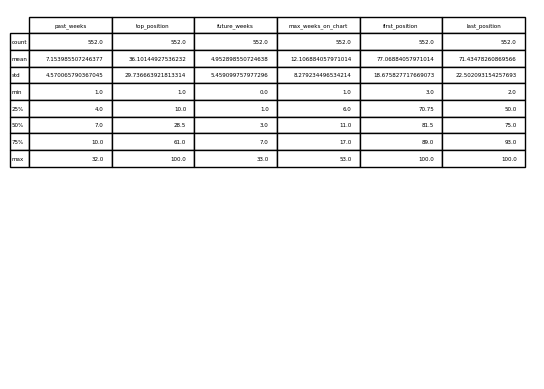

Not-hitmakers


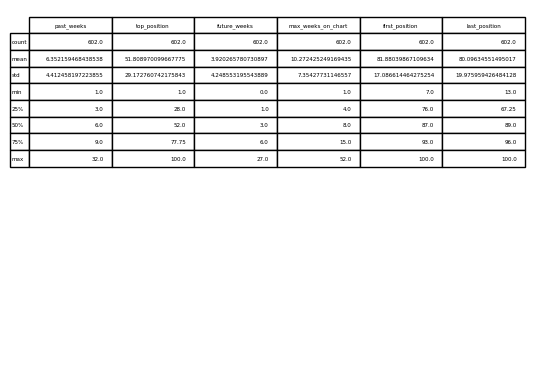

In [18]:
print("Hitmakers")
hitmakers_subdf_6th = hitmakers[hitmakers["song_name"] == hitmakers["6th_song"]]
hitmakers_subdf = hitmakers_subdf_6th[["artist", "song_name"] + features].drop_duplicates()
hitmakers_describe = hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/hitmakers_statistics_6th_song.pdf', format="pdf")
plt.show()

print("Not-hitmakers")
not_hitmakers_subdf_6th = not_hitmakers[not_hitmakers["song_name"] == not_hitmakers["6th_song"]]
not_hitmakers_subdf = not_hitmakers_subdf_6th[["artist", "song_name"] + features].drop_duplicates()
not_hitmakers_describe = not_hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, not_hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/not_hitmakers_statistics_6th_song.pdf', format="pdf")
plt.show()

### 10th song

Hitmakers


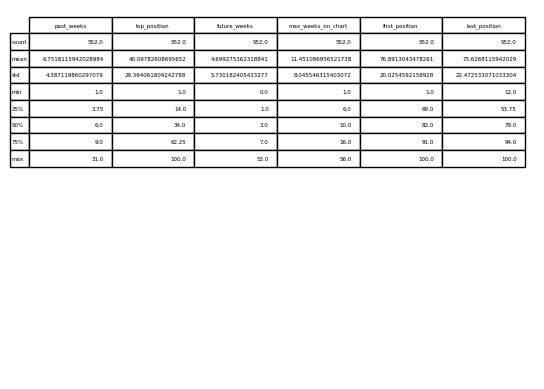

Not-hitmakers


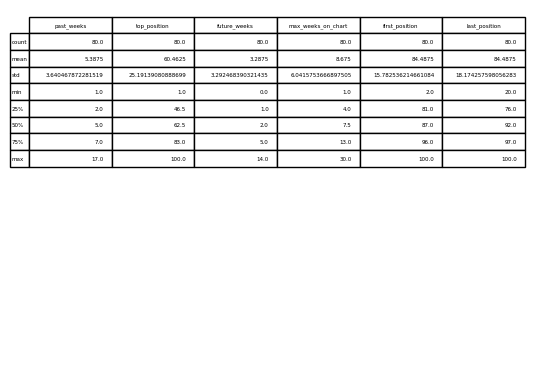

In [19]:
print("Hitmakers")
hitmakers_subdf_10th = hitmakers[hitmakers["song_name"] == hitmakers["10th_song"]]
hitmakers_subdf = hitmakers_subdf_10th[["artist", "song_name"] + features].drop_duplicates()
hitmakers_describe = hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/hitmakers_statistics_10th_song.pdf', format="pdf")
plt.show()

print("Not-hitmakers")
not_hitmakers_subdf_10th = not_hitmakers[not_hitmakers["song_name"] == not_hitmakers["10th_song"]]
not_hitmakers_subdf = not_hitmakers_subdf_10th[["artist", "song_name"] + features].drop_duplicates()
not_hitmakers_describe = not_hitmakers_subdf[features].describe()
plot = plt.subplot(111, frame_on=False)

#remove axis
plot.xaxis.set_visible(False) 
plot.yaxis.set_visible(False) 

#create the table plot and position it in the upper left corner
table(plot, not_hitmakers_describe, loc='upper right')
#save the plot as a png file
plt.savefig(f'figures/not_hitmakers_statistics_10th_song.pdf', format="pdf")
plt.show()

## Diffusion/Jumps analysis

In [20]:
def calculate_position_difference(position, last_week_position):
    if np.isnan(last_week_position):
        return np.nan
    return np.abs(last_week_position - position)

billboard_hot_100["position_change"] = billboard_hot_100.apply(
    lambda x: calculate_position_difference(x["position"], x["last_week_position"]), axis=1)

In [21]:
print(billboard_hot_100["position_change"].mean())
print(billboard_hot_100["position_change"].median())
print(billboard_hot_100["position_change"].quantile(0.9))

6.93840342583395
5.0
16.0


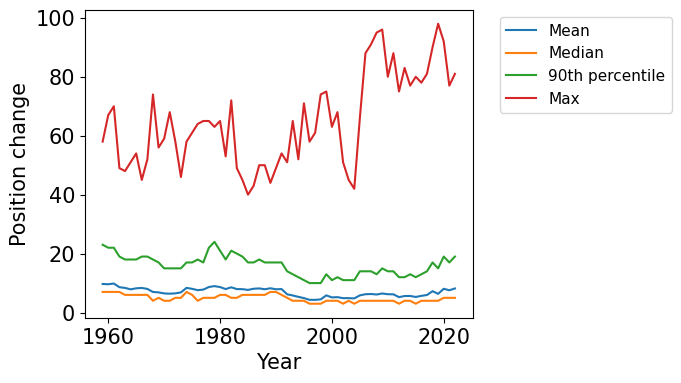

In [22]:
plt.figure(figsize=(5, 4))

mean_jumps = []
median_jumps = []
quantile_jumps = []
max_jumps = []
for year in range(1959, 2023):
    songs_from_year = billboard_hot_100[billboard_hot_100["year"] == year]
    mean_jumps.append(songs_from_year["position_change"].mean())
    median_jumps.append(songs_from_year["position_change"].median())
    quantile_jumps.append(songs_from_year["position_change"].quantile(0.9))
    max_jumps.append(songs_from_year["position_change"].max())

plt.plot(range(1959, 2023), mean_jumps, label="Mean")
plt.plot(range(1959, 2023), median_jumps, label="Median")
plt.plot(range(1959, 2023), quantile_jumps, label="90th percentile")
plt.plot(range(1959, 2023), max_jumps, label="Max")
plt.legend(fontsize=11, bbox_to_anchor=(1.05, 1), loc='upper left')
plt.xlabel("Year")
plt.ylabel("Position change")
plt.savefig(f'figures/position_change_over_years.pdf', format="pdf", bbox_inches='tight')
plt.show()

## Diffusion vs Levy jumps

In [23]:
billboard_hot_100["diffusion_jump"] = billboard_hot_100["position_change"] < 15

In [24]:
billboard_hot_100["diffusion_jump"].mean()

0.7924657144483014

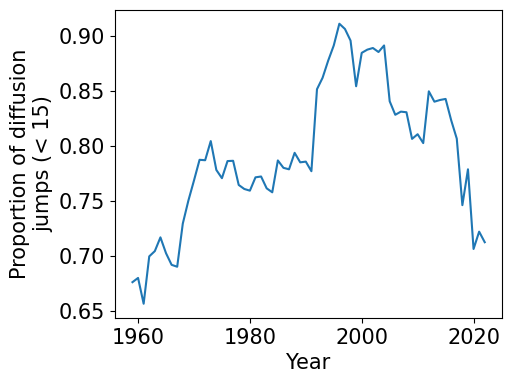

In [25]:
plt.figure(figsize=(5, 4))

diffusion_jumps = []
for year in range(1959, 2023):
    songs_from_year = billboard_hot_100[billboard_hot_100["year"] == year]
    diffusion_jumps.append(songs_from_year["diffusion_jump"].mean())

plt.plot(range(1959, 2023), diffusion_jumps)
plt.xlabel("Year")
plt.ylabel("Proportion of diffusion\njumps (< 15)")
plt.savefig(f'figures/position_change_over_years.pdf', format="pdf", bbox_inches='tight')
plt.show()

## Trajectories of artists' top position

In [26]:
songs_numbers_count = billboard_hot_100[["year", "artist", "song_name"]].groupby(["year", "artist"])["song_name"].nunique().reset_index(name="number_of_songs")

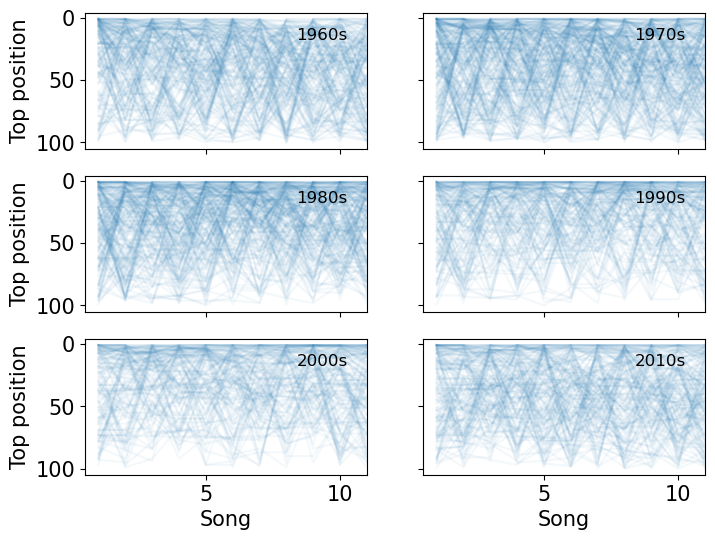

In [37]:
distinct_artist_songs = billboard_hot_100.sort_values(by="first_day_of_the_week")[[
    "artist", "song_name", "top_position", "year"]].drop_duplicates()

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for decade in range(1960, 2020, 10):
    songs_until_decade = songs_numbers_count[songs_numbers_count["year"] < decade + 10].copy()
    songs_until_decade["total_number_of_songs"] = songs_until_decade.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_until_decade = songs_until_decade[(songs_until_decade["year"] >= decade) &\
                                            (songs_until_decade["year"] < decade + 10)][[
        "artist", "total_number_of_songs"]].drop_duplicates()

    hitmakers_from_decade = songs_until_decade[songs_until_decade[
        "total_number_of_songs"] > 10]

    distinct_artist_songs_until_decade = distinct_artist_songs[distinct_artist_songs["year"] < decade + 10]
    for artist in hitmakers_from_decade["artist"].unique():
        top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
        axes[row_i, col_i].plot(range(1, len(top_positions) + 1), top_positions, label=artist, alpha=0.05,
                                color="C0")

    axes[row_i, col_i].text(0.75, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Song")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Top position")
    axes[row_i, col_i].set_xlim(0.5, 11)
    
    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.gca().invert_yaxis()
plt.savefig(f'figures/top_positions_over_time_hitmakers.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Not hitmakers

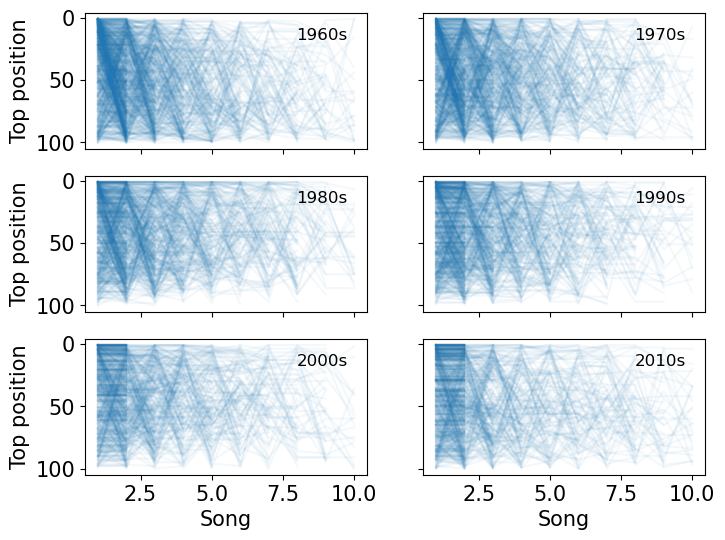

In [28]:
distinct_artist_songs = billboard_hot_100.sort_values(by="first_day_of_the_week")[[
    "artist", "song_name", "top_position", "year"]].drop_duplicates()

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for decade in range(1960, 2020, 10):
    songs_until_decade = songs_numbers_count[songs_numbers_count["year"] < decade + 10].copy()
    songs_until_decade["total_number_of_songs"] = songs_until_decade.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_until_decade = songs_until_decade[(songs_until_decade["year"] >= decade) &\
                                            (songs_until_decade["year"] < decade + 10)][[
        "artist", "total_number_of_songs"]].drop_duplicates()

    not_hitmakers_from_decade = songs_until_decade[songs_until_decade[
        "total_number_of_songs"] <= 10]
    
    distinct_artist_songs_until_decade = distinct_artist_songs[distinct_artist_songs["year"] < decade + 10]

    for artist in not_hitmakers_from_decade["artist"].unique():
        top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
        axes[row_i, col_i].plot(range(1, len(top_positions) + 1), top_positions, label=artist, alpha=0.05,
                                color="C0")

    axes[row_i, col_i].text(0.75, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Song")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Top position")

    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.gca().invert_yaxis()
plt.savefig(f'figures/top_positions_over_time_not_hitmakers.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Average

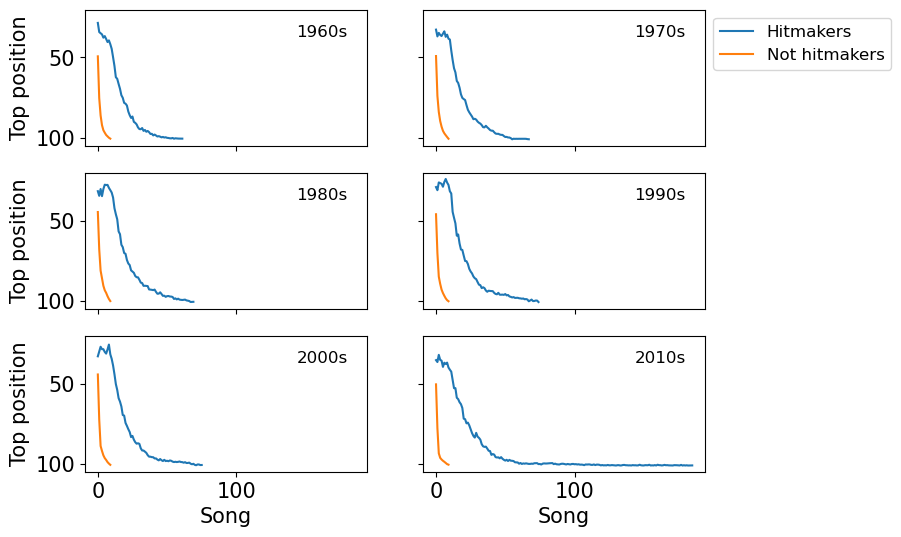

In [29]:
distinct_artist_songs = billboard_hot_100.sort_values(by="first_day_of_the_week")[[
    "artist", "song_name", "top_position", "year"]].drop_duplicates()

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for decade in range(1960, 2020, 10):
    songs_until_decade = songs_numbers_count[songs_numbers_count["year"] < decade + 10].copy()
    songs_until_decade["total_number_of_songs"] = songs_until_decade.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_until_decade = songs_until_decade[(songs_until_decade["year"] >= decade) &\
                                            (songs_until_decade["year"] < decade + 10)][[
        "artist", "total_number_of_songs"]].drop_duplicates()

    hitmakers_from_decade = songs_until_decade[songs_until_decade[
        "total_number_of_songs"] > 10]
    
    not_hitmakers_from_decade = songs_until_decade[songs_until_decade[
        "total_number_of_songs"] <= 10]
    
    distinct_artist_songs_until_decade = distinct_artist_songs[distinct_artist_songs["year"] < decade + 10]

    top_positions_artist = []
    not_hitmakers_top_positions_artist = []
    for artist in hitmakers_from_decade["artist"].unique():
        top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
        top_positions_artist.append(top_positions.tolist())
    for artist in not_hitmakers_from_decade["artist"].unique():
        top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
        not_hitmakers_top_positions_artist.append(top_positions.tolist())

    max_len = max([len(top_positions) for top_positions in top_positions_artist])
    max_len_not_hitmakers = max([len(top_positions) for top_positions in not_hitmakers_top_positions_artist])
    mean_array = []
    mean_array_not_hitmakers = []
    for i in range(len(top_positions_artist)):
        top_positions_artist[i] = np.pad(top_positions_artist[i], (0, max_len - len(top_positions_artist[i])), constant_values=101)
    for i in range(len(not_hitmakers_top_positions_artist)):
        not_hitmakers_top_positions_artist[i] = np.pad(not_hitmakers_top_positions_artist[i], (0, max_len_not_hitmakers - len(not_hitmakers_top_positions_artist[i])), constant_values=101)
    for i in range(max_len):
        mean_array.append(np.mean([top_positions[i] for top_positions in top_positions_artist]))
    for i in range(max_len_not_hitmakers):
        mean_array_not_hitmakers.append(np.mean([top_positions[i] for top_positions in not_hitmakers_top_positions_artist]))
    axes[row_i, col_i].plot(range(max_len), mean_array, color="C0")
    axes[row_i, col_i].plot(range(max_len_not_hitmakers), mean_array_not_hitmakers, color="C1")
    axes[row_i, col_i].text(0.75, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Song")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Top position")
    if (row_i == 0) and col_i == 1:
        axes[row_i, col_i].legend(["Hitmakers", "Not hitmakers"], loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.gca().invert_yaxis()
plt.savefig(f'figures/top_positions_over_time_normalized.pdf', format="pdf", bbox_inches='tight')
plt.show()

### Don't count fewer songs as 101

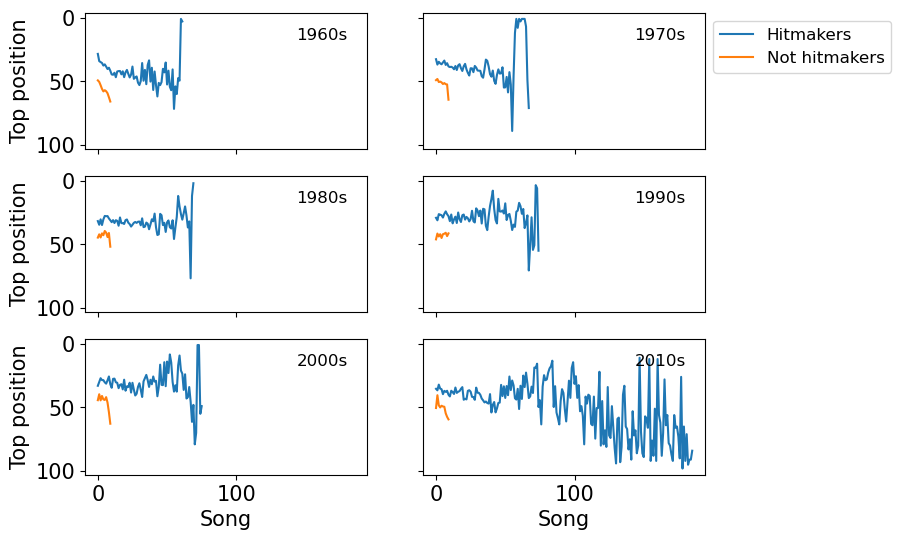

In [30]:
distinct_artist_songs = billboard_hot_100.sort_values(by="first_day_of_the_week")[[
    "artist", "song_name", "top_position", "year"]].drop_duplicates()

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for decade in range(1960, 2020, 10):
    songs_until_decade = songs_numbers_count[songs_numbers_count["year"] < decade + 10].copy()
    songs_until_decade["total_number_of_songs"] = songs_until_decade.groupby(["artist"])["number_of_songs"].transform("sum")
    songs_until_decade = songs_until_decade[(songs_until_decade["year"] >= decade) &\
                                            (songs_until_decade["year"] < decade + 10)][[
        "artist", "total_number_of_songs"]].drop_duplicates()

    hitmakers_from_decade = songs_until_decade[songs_until_decade[
        "total_number_of_songs"] > 10]
    
    not_hitmakers_from_decade = songs_until_decade[songs_until_decade[
        "total_number_of_songs"] <= 10]
    
    distinct_artist_songs_until_decade = distinct_artist_songs[distinct_artist_songs["year"] < decade + 10]

    top_positions_artist = []
    not_hitmakers_top_positions_artist = []
    for artist in hitmakers_from_decade["artist"].unique():
        top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
        top_positions_artist.append(top_positions.tolist())
    for artist in not_hitmakers_from_decade["artist"].unique():
        top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
        not_hitmakers_top_positions_artist.append(top_positions.tolist())

    max_len = max([len(top_positions) for top_positions in top_positions_artist])
    max_len_not_hitmakers = max([len(top_positions) for top_positions in not_hitmakers_top_positions_artist])
    mean_array = []
    mean_array_not_hitmakers = []

    for i in range(max_len):
        mean_array.append(np.mean([top_positions[i] for top_positions in top_positions_artist if len(top_positions) > i]))
    for i in range(max_len_not_hitmakers):
        mean_array_not_hitmakers.append(np.mean([top_positions[i] for top_positions in not_hitmakers_top_positions_artist if len(top_positions) > i]))
    axes[row_i, col_i].plot(range(max_len), mean_array, color="C0")
    axes[row_i, col_i].plot(range(max_len_not_hitmakers), mean_array_not_hitmakers, color="C1")
    axes[row_i, col_i].text(0.75, 0.8, f"{decade}s", transform=axes[row_i, col_i].transAxes, fontsize=12)
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Song")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Top position")
    if (row_i == 0) and col_i == 1:
        axes[row_i, col_i].legend(["Hitmakers", "Not hitmakers"], loc="upper left", bbox_to_anchor=(1, 1), fontsize=12)

    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

plt.gca().invert_yaxis()
plt.show()

## Individual

In [31]:
popular_artists = ["The Beatles", "Elton John", "Madonna", "Taylor Swift", "Drake", "Beyonce"]

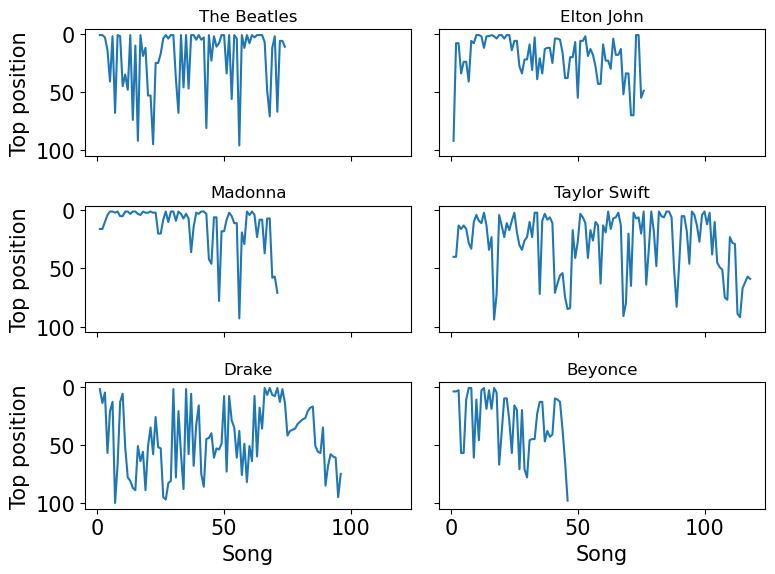

In [32]:
distinct_artist_songs = billboard_hot_100.sort_values(by="first_day_of_the_week")[[
    "artist", "song_name", "top_position", "year"]].drop_duplicates()

fig, axes = plt.subplots(3, 2, figsize=(8, 6), sharex=True, sharey=True)
row_i, col_i = 0, 0

for artist in popular_artists:
    hitmakers_top_positions = distinct_artist_songs_until_decade[distinct_artist_songs_until_decade["artist"] == artist]["top_position"]
    
    axes[row_i, col_i].plot(range(1, len(hitmakers_top_positions) + 1), hitmakers_top_positions, color="C0")
    if row_i == 2:
        axes[row_i, col_i].set_xlabel("Song")
    if col_i == 0:
        axes[row_i, col_i].set_ylabel("Top position")
    axes[row_i, col_i].set_title(f"{artist}", fontsize=12)

    col_i += 1
    if col_i == 2:
        row_i += 1
        col_i = 0

fig.tight_layout()
plt.gca().invert_yaxis()
plt.savefig(f'figures/top_positions_over_time_popular_artists.pdf', format="pdf", bbox_inches='tight')
plt.show()

## Predicting hitmakers

In [38]:
features = ["past_weeks", "top_position", "future_weeks", "max_weeks_on_chart", "first_position", "last_position"]

In [62]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier

billboard_hot_100["hitmaker"] = billboard_hot_100["number_of_songs"] > 10
billboard_hot_100["hitmaker"] = billboard_hot_100["hitmaker"].astype(int)

y = billboard_hot_100["hitmaker"]
X = billboard_hot_100[features]

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=42)
# # grid search
# # refremce http://scott.fortmann-roe.com/docs/BiasVariance.html
# from sklearn.model_selection import GridSearchCV

# knn = KNeighborsClassifier()
# param_grid = {'n_neighbors': np.arange(1, 25)}
# knn_cv = GridSearchCV(knn, param_grid, cv=5)
# knn_cv.fit(X_train, y_train)

# print(knn_cv.best_params_)

knn = KNeighborsClassifier(n_neighbors=1)
knn.fit(X_train, y_train)

y_pred = knn.predict(X_test)

from sklearn.metrics import accuracy_score

print(f"Accuracy: {accuracy_score(y_test, y_pred)}")

from sklearn.metrics import confusion_matrix

print(confusion_matrix(y_test, y_pred))


Accuracy: 0.9876306568031388
[[40176   381]
 [  445 25776]]


In [63]:
## calculate rss, bias and variance
from sklearn.metrics import mean_squared_error

y_pred_train = knn.predict(X_train)
y_pred_test = knn.predict(X_test)

print(f"RSS train: {mean_squared_error(y_train, y_pred_train)}")
print(f"RSS test: {mean_squared_error(y_test, y_pred_test)}")

print(f"Bias: {np.mean(y_pred_train != y_train)}")
print(f"Variance: {np.var(y_pred_train)}")

RSS train: 0.011119056265419735
RSS test: 0.012369343196861242
Bias: 0.011119056265419735
Variance: 0.23791769341745328
